In [1]:
import tensorflow as tf
import numpy as np                                
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
import h5py
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
tf.random.set_seed(42)

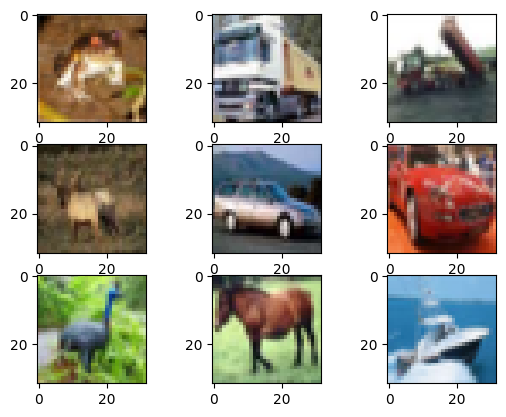

In [3]:
#load data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
img_rows, img_cols , channels= 32,32,3
for i in range(0,9):
    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i])
plt.show()

In [4]:
# set up image augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.3
    )
datagen.fit(x_train)

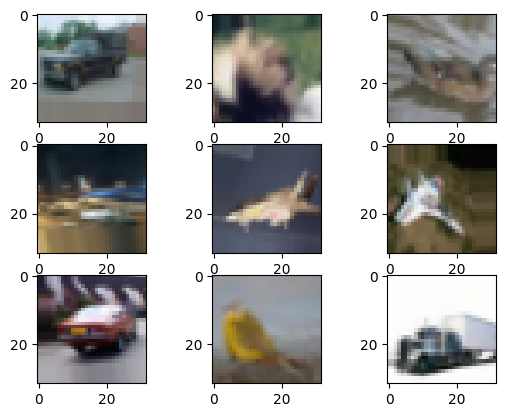

In [5]:
# see example augmentation images
for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].astype(np.uint8))
    plt.show()
    break

In [6]:
#reshape into images
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)
input_shape = (img_rows, img_cols, 1)
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [7]:
#convert integers to float; normalise and center the mean
x_train=x_train.astype("float32")  
x_test=x_test.astype("float32")
mean=np.mean(x_train)
std=np.std(x_train)
x_test=(x_test-mean)/std
x_train=(x_train-mean)/std

In [8]:
# labels
num_classes=10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [9]:
# build again, same model as model1

#reg=l2(1e-4)   # L2 or "ridge" regularisation
reg=None
reg2=None
num_filters = 32
ac = 'relu'
adm = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)  # Remove decay argument
opt = adm
drop_dense = 0.5
drop_conv=0

model = Sequential(name='cifar10')

model.add(Conv2D(num_filters, (3, 3), activation=ac, kernel_regularizer=reg, input_shape=(img_rows, img_cols, channels), padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(num_filters, (3, 3), activation=ac,kernel_regularizer=reg, padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 16x16x3xnum_filters
model.add(Dropout(drop_conv))

model.add(Conv2D(2*num_filters, (3, 3), activation=ac, kernel_regularizer=reg, padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(2*num_filters, (3, 3), activation=ac, kernel_regularizer=reg, padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 8x8x3x(2*num_filters)
model.add(Dropout(drop_conv))

model.add(Conv2D(4*num_filters, (3, 3), activation=ac,kernel_regularizer=reg, padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(4*num_filters, (3, 3), activation=ac,kernel_regularizer=reg, padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 4x4x3x(4*num_filters)
model.add(Dropout(drop_conv))

model.add(Flatten())
model.add(Dense(2048, activation=ac, kernel_regularizer=reg2, name='hidden_1'))
model.add(BatchNormalization())
model.add(Dropout(drop_dense))
model.add(Dense(2048, activation=ac, kernel_regularizer=reg2, name='hidden_2'))
model.add(BatchNormalization())
model.add(Dropout(drop_dense))
model.add(Dense(1024, activation=ac, kernel_regularizer=reg2, name='hidden_4'))
model.add(BatchNormalization())
model.add(Dropout(drop_dense))
model.add(Dense(512, activation=ac, kernel_regularizer=reg2, name='hidden_5'))
model.add(BatchNormalization())
model.add(Dropout(drop_dense))
model.add(Dense(num_classes, activation='softmax', name='output'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=opt)

In [10]:
model.summary()

Model: "cifar10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                           

In [11]:
checkpoint = ModelCheckpoint("cifar10_best_result1.h5", save_best_only=True)

In [12]:
# train with image augmentation
history=model.fit(datagen.flow(x_train, y_train, batch_size=256),
                    steps_per_epoch = len(x_train) / 256, epochs=15, 
                  validation_data=(x_test, y_test), callbacks=[checkpoint])

Epoch 1/15


196/195 [==============================] - ETA: 0s - loss: 2.1252 - accuracy: 0.3215

C:\Users\olegd\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


195/195 [==============================] - 240s 1s/step - loss: 2.1252 - accuracy: 0.3215 - val_loss: 2.6359 - val_accuracy: 0.1843
Epoch 2/15
195/195 [==============================] - 250s 1s/step - loss: 1.5390 - accuracy: 0.4546 - val_loss: 1.3381 - val_accuracy: 0.5185
Epoch 3/15
195/195 [==============================] - 237s 1s/step - loss: 1.3211 - accuracy: 0.5281 - val_loss: 1.1999 - val_accuracy: 0.5996
Epoch 4/15
195/195 [==============================] - 236s 1s/step - loss: 1.1684 - accuracy: 0.5842 - val_loss: 1.0297 - val_accuracy: 0.6474
Epoch 5/15
195/195 [==============================] - 238s 1s/step - loss: 1.0508 - accuracy: 0.6289 - val_loss: 0.9629 - val_accuracy: 0.6780
Epoch 6/15
195/195 [==============================] - 236s 1s/step - loss: 0.9674 - accuracy: 0.6629 - val_loss: 0.9599 - val_accuracy: 0.6826
Epoch 7/15
195/195 [==============================] - 235s 1s/step - loss: 0.8985 - accuracy: 0.6879 - val_loss: 0.7625 - val_accuracy: 0.7373
Epoch 8/15

In [13]:
# plotting helper function
def plothist(hist):
    plt.rcParams["figure.figsize"] = (16, 8)
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.grid()
    plt.show()

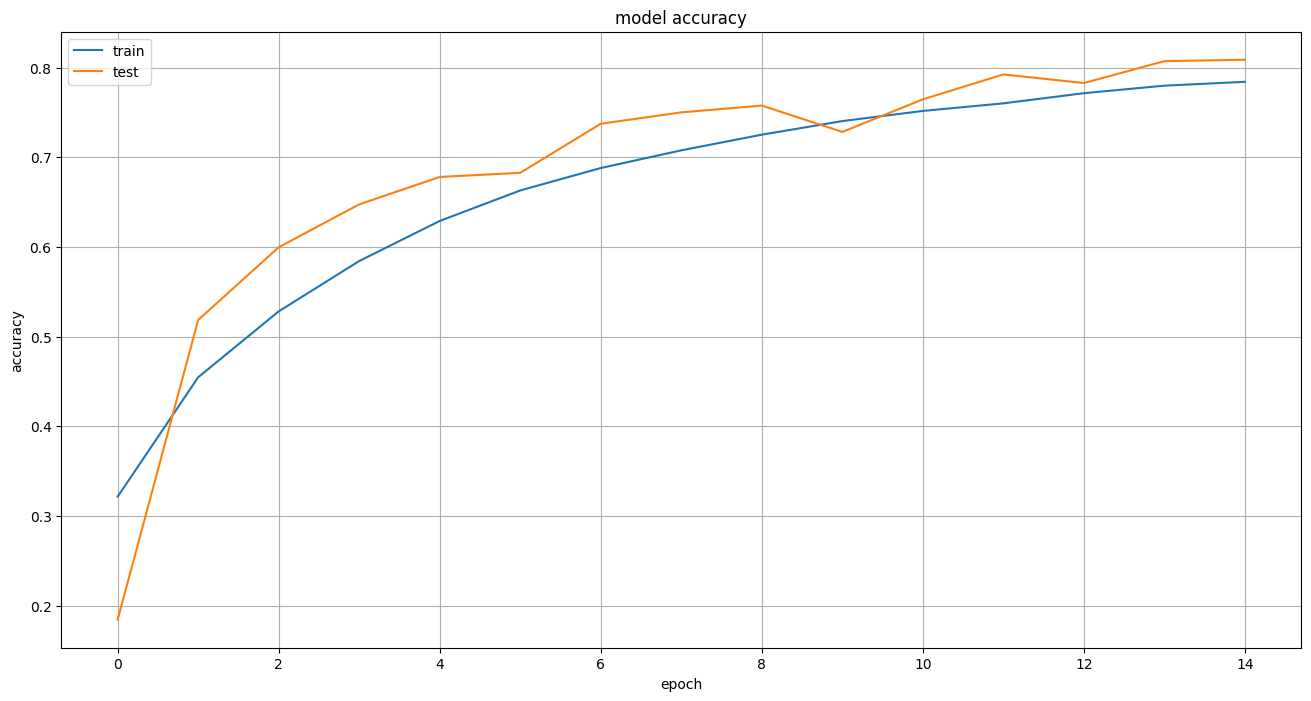

In [14]:
plothist(history)

In [15]:
model_test_acc=model.evaluate(x_test,y_test, batch_size=128)
model_test_acc

79/79 [==============================] - 10s 128ms/step - loss: 0.5643 - accuracy: 0.8087


[0.5642764568328857, 0.8087000250816345]

In [16]:
model_train_acc=model.evaluate(x_train,y_train, batch_size=128)
model_train_acc

391/391 [==============================] - 52s 134ms/step - loss: 0.4804 - accuracy: 0.8329


[0.48039543628692627, 0.8329200148582458]

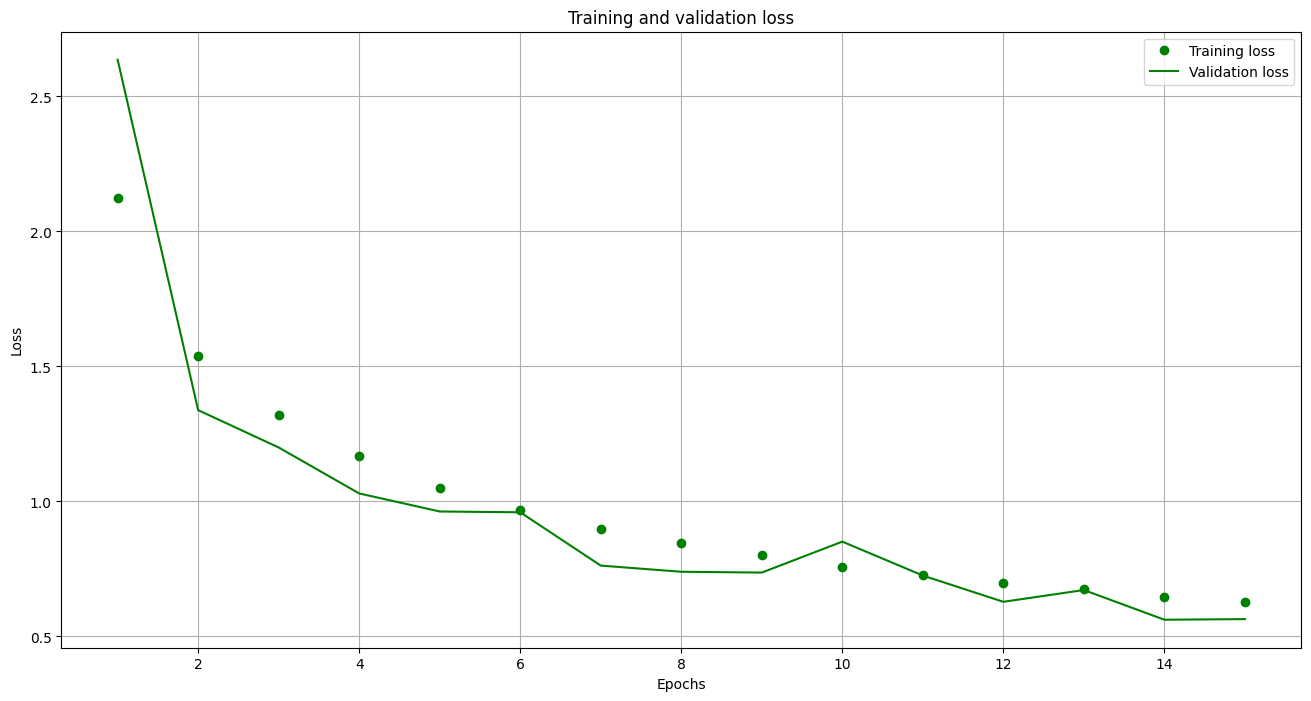

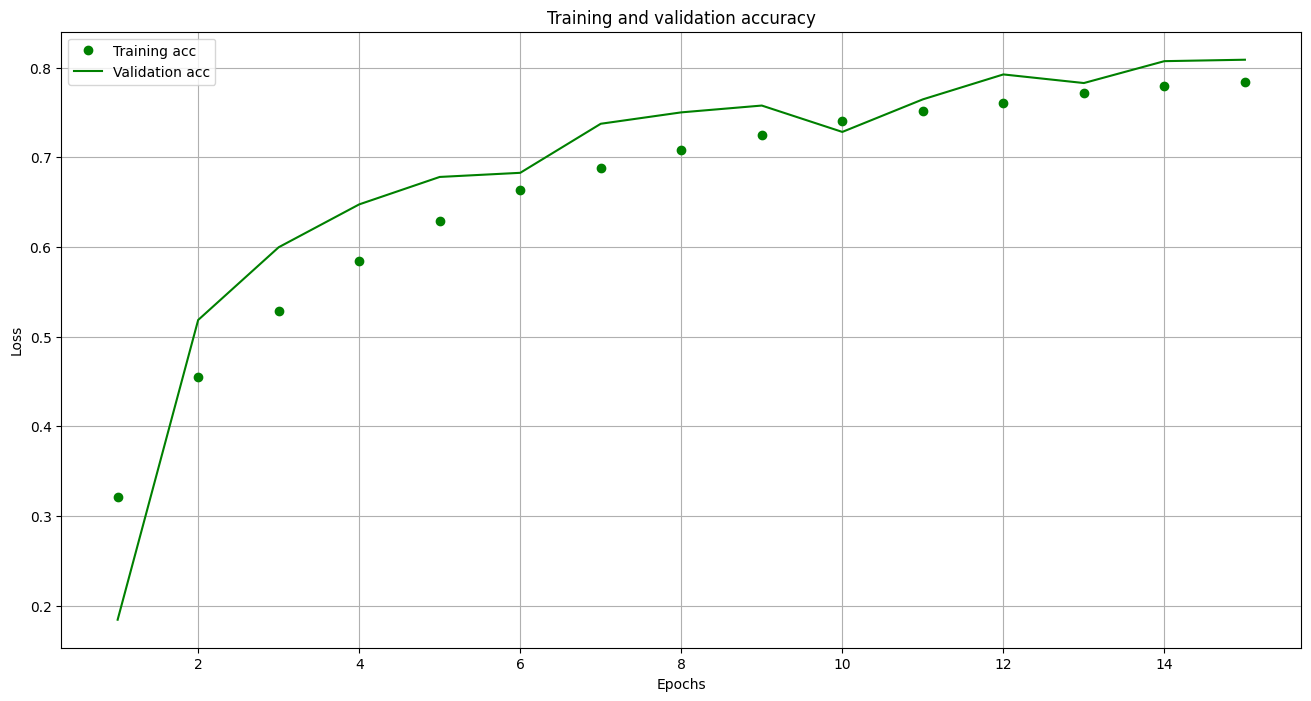

In [17]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['accuracy']) + 1)

plt.rcParams["figure.figsize"] = (16, 8)
plt.plot(epochs, loss_values, 'go', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

plt.plot(epochs, history_dict['accuracy'], 'go', label='Training acc')
plt.plot(epochs, history_dict['val_accuracy'], 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()